In [ ]:
# Change this to the div2k path
div2k_path = '/content/drive/MyDrive/Datasets/div2k'

### 1. Create a Custom Dataset

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from torchvision.io import read_image
from PIL import Image

In [ ]:
# Define the data path (Pls change to the correct path for div2k dataset if you run on local machine)
train_lr_path = "/content/drive/MyDrive/Datasets/div2k/DIV2K_train_LR_bicubic/X4" # CHANGE THIS
train_hr_path = "/content/drive/MyDrive/Datasets/div2k/DIV2K_train_HR" # CHANGE THIS

test_lr_path = "/content/drive/MyDrive/Datasets/div2k/DIV2K_valid_LR_bicubic/X4" # CHANGE THIS
test_hr_path = "/content/drive/MyDrive/Datasets/div2k/DIV2K_valid_HR" # CHANGE THIS

In [ ]:
# Sort all data
train_ld_lr = sorted(os.listdir(train_lr_path))[:400]
train_ld_hr = sorted(os.listdir(train_hr_path))[:400]

test_ld_lr = sorted(os.listdir(test_lr_path))
test_ld_hr = sorted(os.listdir(test_hr_path))

In [ ]:
# Preprocess data
class DIV2K_x4(Dataset):
  def __init__(self, ld_lr: list, ld_hr: list, lr_path: str, hr_path: str, len: int):
    self.ld_lr = ld_lr
    self.ld_hr = ld_hr

    self.lr_path = lr_path
    self.hr_path = hr_path
    self.transform = ToTensor()
    self.len = len

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    lr_img_path = os.path.join(self.lr_path, self.ld_lr[idx])
    hr_img_path = os.path.join(self.hr_path, self.ld_hr[idx])

    lr_open_img = Image.open(lr_img_path)
    hr_open_img = Image.open(hr_img_path)


    lr_img = self.transform(lr_open_img)
    hr_img = self.transform(hr_open_img)

    lr_open_img.close()
    hr_open_img.close()

    return lr_img, hr_img


In [ ]:
train_set = DIV2K_x4(ld_lr = train_ld_lr,
                     ld_hr = train_ld_hr,
                     lr_path = train_lr_path,
                     hr_path = train_hr_path,
                     len = 400)

test_set = DIV2K_x4(ld_lr = test_ld_lr,
                    ld_hr = test_ld_hr,
                    lr_path = test_lr_path,
                    hr_path = test_hr_path,
                    len = 100)

train_dataloader = DataLoader(train_set, batch_size = 1, shuffle = True)
test_dataloader = DataLoader(test_set, batch_size = 1, shuffle = False)

print(len(train_dataloader), len(test_dataloader))

torch.Size([1, 3, 297, 510])
torch.Size([1, 3, 1188, 2040])


(-0.5, 2039.5, 1187.5, -0.5)

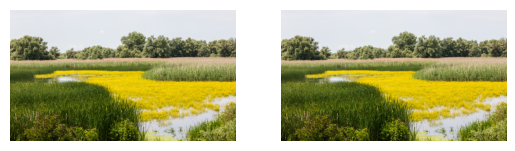

In [ ]:
# View data in your dataset
import torchvision.transforms.functional as F

lr, hr = next(iter(train_dataloader))
print(lr.shape)
print(hr.shape)

plt.subplot(1, 2, 1)
plt.imshow(F.to_pil_image(lr.squeeze()))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(F.to_pil_image(hr.squeeze()))
plt.axis(False)


torch.Size([1, 3, 339, 510])
torch.Size([1, 3, 1356, 2040])


(-0.5, 2039.5, 1355.5, -0.5)

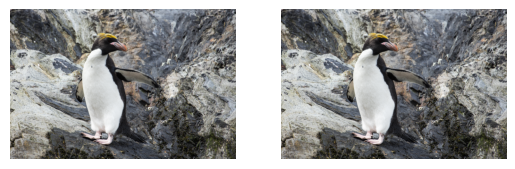

In [ ]:
import torchvision.transforms.functional as F

lr, hr = next(iter(test_dataloader))
print(lr.shape)
print(hr.shape)

plt.subplot(1, 2, 1)
plt.imshow(F.to_pil_image(lr.squeeze()))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(F.to_pil_image(hr.squeeze()))
plt.axis(False)


### 2. Create Model

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm

In [ ]:
# Build ESPCN model
class ESPCN(nn.Module):
    def __init__(self):
        super().__init__()

        # Feature mapping
        self.feature_maps = nn.Sequential(
            nn.Conv2d(3, 64, (5, 5), (1, 1), (2, 2)),
            nn.Tanh(),
            nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1)),
            nn.Tanh(),
        )

        # Sub-pixel convolution layer
        self.sub_pixel = nn.Sequential(
            nn.Conv2d(32, 3*16, (3, 3), (1, 1), (1, 1)),
            nn.PixelShuffle(4),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.feature_maps(x)
        x = self.sub_pixel(x)
        x = torch.clamp_(x, 0.0, 1.0)
        return x

In [ ]:
# Define the train step
def train_step(model: torch.nn.Module,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               dataloader: torch.utils.data.DataLoader,
               device: torch.device):
  """Perform training step and return the training loss"""
  train_loss = 0
  model.train()
  for lr, hr in tqdm(dataloader):
    lr, hr = lr.to(device), hr.to(device)
    # 1. Forward pass
    hr_pred = model(lr)
    # 2. Loss
    loss = loss_fn(hr_pred, hr)
    train_loss += loss.detach()
    # train_loss += loss.cpu().detach().item()
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. backward
    loss.backward()
    # 5. optimizer step
    optimizer.step()
  train_loss = train_loss / len(dataloader)
  return train_loss

In [ ]:
# Define the test step
def test_step(model: torch.nn.Module,
               loss_fn: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               device: torch.device):
  """Perform the testing step and return testing loss and accuracy"""
  test_loss = 0
  model.eval()
  with torch.inference_mode():
    for lr, hr in tqdm(dataloader):
      lr, hr = lr.to(device), hr.to(device)
      # forward pass
      hr_pred = model(lr)
      # loss
      test_loss += loss_fn(hr_pred, hr)

  test_loss = test_loss / len(dataloader)

  return test_loss

In [ ]:
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

'cpu'

In [ ]:
saved_model_path = "espcn_div2k_x4.pth"

torch.manual_seed(42)
khang_model = ESPCN()
khang_model.load_state_dict(torch.load(f = saved_model_path, map_location=torch.device("cpu")))
khang_model.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params= khang_model.parameters(), lr = 0.01)

In [ ]:
# Start training
torch.manual_seed(42)
epochs = 1

for epoch in tqdm(range(epochs)):
  train_loss = train_step(model = khang_model,
                          loss_fn = loss_fn,
                          optimizer = optimizer,
                          dataloader = train_dataloader,
                          device = device)

  # test_loss, acc = test_step(model = khang_model,
  #           loss_fn = loss_fn,
  #           dataloader = test_dataloader,
  #           device = device)
  # print out what's happening

  print(f"Epoch: {epoch} | train_loss = {train_loss: .4f}")

  # print(f"Epoch: {epoch} | train_loss = {train_loss: .4f} | test_loss = {test_loss: .4f}")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 0 | train_loss =  0.2352


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 1 | train_loss =  0.2454


In [ ]:
# Save weight for future used
torch.save(obj = khang_model.state_dict(), f = saved_model_path)

# Evaluation

In [ ]:
espcn_model = ESPCN()
model_path = "espcn_div2k_x4.pth"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    espcn_model.load_state_dict(torch.load(f = model_path))
else:
    espcn_model.load_state_dict(torch.load(f = model_path, map_location=torch.device("cpu")))

In [ ]:
lr, hr = next(iter(test_dataloader))

espcn_model.eval()
with torch.no_grad():
    output = espcn_model(lr)
    output = output.cpu().detach().numpy().squeeze().transpose(1,2,0)

plt.subplot(1, 2, 1)
plt.imshow(F.to_pil_image(output))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(F.to_pil_image(hr.squeeze()))
plt.axis(False)